In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
# path to train and test files
train_path = '/content/train.csv'
test_path = '/content/test.csv'

In [ ]:
# Load train and test data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

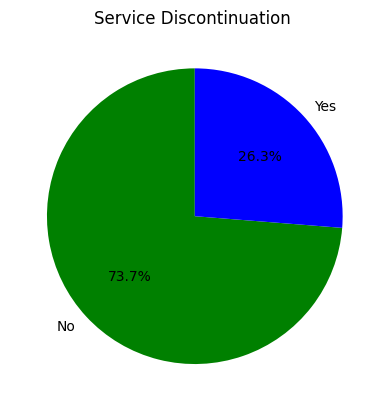

In [ ]:
# Drop the customerID column
train_df = train_df.drop('customerID', axis=1)

# Clean the data
train_df['TotalCharges'].fillna(train_df['TotalCharges'].median(), inplace=True)

# Get categorical features
categorical_features = [column for column in train_df.columns if train_df[column].dtype == 'object']

# Data exploration and check that if the data is balanced
feature = categorical_features[-1]
colors = ['green', 'blue']
plt.pie(train_df[feature].value_counts(), labels = train_df[feature].value_counts().index,autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Service Discontinuation ')
plt.savefig('service_disc')

# Encode the training data
label_mapping = {}
label_encoder = LabelEncoder()
for column in train_df.columns:
    if train_df[column].dtype == 'object':
        train_df[column] = label_encoder.fit_transform(train_df[column])
        label_mapping[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


# Get rid of the target column
X = train_df.drop('Discontinued', axis=1)
# Labels
y = train_df['Discontinued']

# Create train, validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)



In [ ]:
# Set up an AdaBoost model and fit the data
model = AdaBoostClassifier(n_estimators=20, learning_rate = 0.4, random_state=42)
model.fit(X_train, y_train)

# Train the best model and make predictions:
y_pred_prob= model.predict_proba(X_val)[:,1]
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')

# Perform a Gridsearch for best hyperparameters:
grid = { 'n_estimators': list(range(1,100)),
'learning_rate': [0.2, 0.3, 0.4]
         }
grid_search = GridSearchCV(model, grid, cv=None, scoring='roc_auc', return_train_score=True, n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters
params = grid_search.cv_results_['params']
best_estimator = grid_search.best_estimator_
best_learning = best_estimator.learning_rate
best_num_estimators = best_estimator.n_estimators


ROC AUC Score: 0.8584734685367399


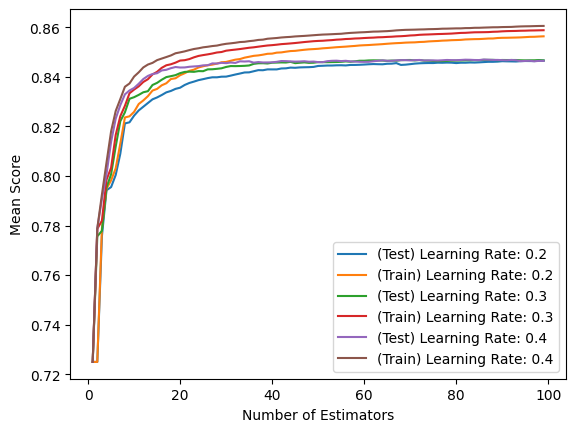

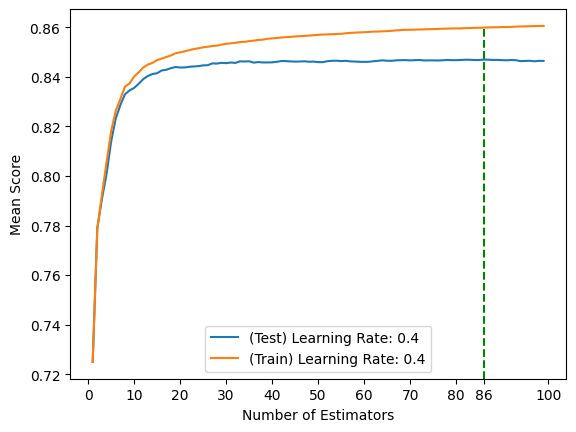

In [ ]:
# Plotting results of grid search
results = grid_search.cv_results_

n_estimators = results['param_n_estimators']
learning_rate = results['param_learning_rate']
mean_test_score = results['mean_test_score']
mean_train_score = results['mean_train_score']

# # Plotting n_estimators vs mean test score for each learning rate
# for lr in grid['learning_rate']:
#     plt.plot(n_estimators[learning_rate==lr], mean_test_score[learning_rate==lr], label=f'Learning Rate: {lr}')
# plt.xlabel('Number of Estimators')
# plt.ylabel('Mean Test Score')
# plt.legend()
# plt.show()

# Plotting mean_test_score and mean_train_score vs n_estimators
for lr in grid['learning_rate']:
    plt.plot(n_estimators[learning_rate==lr], mean_test_score[learning_rate==lr], label=f'(Test) Learning Rate: {lr}')
    plt.plot(n_estimators[learning_rate==lr], mean_train_score[learning_rate==lr], label=f'(Train) Learning Rate: {lr}')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Score')
plt.legend()
plt.savefig('meanscore_train_test')
plt.show()

# Plot for the best learning rate
plt.plot(n_estimators[learning_rate==best_learning], mean_test_score[learning_rate==best_learning], label=f'(Test) Learning Rate: {lr}')
plt.plot(n_estimators[learning_rate==best_learning], mean_train_score[learning_rate==best_learning], label=f'(Train) Learning Rate: {lr}')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Score')
plt.axvline(x=86, ymax = 0.95, color='g', linestyle='--')
plt.xticks([10*x for x in range(9)] + [86] + [100])
plt.legend()
plt.savefig('meanscore_best_learning')
plt.show()

In [ ]:
#TEST and SAVE
# Get ID column
IDs = test_df ['customerID']
# Drop customerID from test_df
test_df = test_df.drop('customerID', axis=1)

# Same as training
test_df['TotalCharges'].fillna(test_df['TotalCharges'].median(), inplace=True)

# Encode using the dictionary we get from training encoding
for column in test_df.columns:
    if column in label_mapping:
        test_df[column] = [label_mapping[column][x] for x in test_df[column]]

X_test = test_df
# Make predictions
y_test_pred_probs = model.predict_proba(X_test)[:, 1]

submissions = pd.DataFrame()
submissions['ID'] = IDs
submissions['TARGET'] = y_test_pred_probs
submissions.to_csv('submissions.csv', index=False)